# Fully Convolutional Networks & Transfer Learning

In [2]:
!pip install -U d2l

     |████████████████████████████████| 83 kB 1.2 MB/s 


In [3]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import os

## Dataset
Pascal VOC2012 dataset contains 20 classes. 

The train/val data has 11,530 images containing 27,450 ROI annotated objects and 6,929 segmentations.

In [4]:
#d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
#                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [ ]:
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(
            torchvision.io.read_image(
                os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(
            torchvision.io.read_image(
                os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png'),
                mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

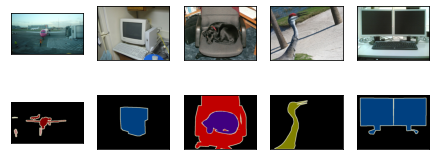

In [ ]:
#show the first five input images and their labels. 
#In the label images, white and black represent borders and background, respectively,
#while the other colors correspond to different classes.
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n);

## Construct FCN using ResNet-18 as backbone

In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]    #showing the last three items in the list

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

## Create fully convolutional network, which copies all the pretrained layers in the ResNet-18 except the last two layers: final global average pooling layer and the fully-connected layer.


In [ ]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])
list(net.children())[-3:] 

## Given an input with height and width of 320 and 480 respectively, the forward propagation of net reduces the input height and width to 1/32 of the original, namely 10 and 15.

In [ ]:
X = torch.rand(size=(1, 3, 320, 480))

In [ ]:
net(X).shape

torch.Size([1, 512, 10, 15])

Next, we use a  1×1  convolutional layer to transform the number of output channels into the number of classes (21) of the Pascal VOC2012 dataset, including the negative background class. Finally, we need to increase the height and width of the feature maps by 32 times to change them back to the height and width of the input image.

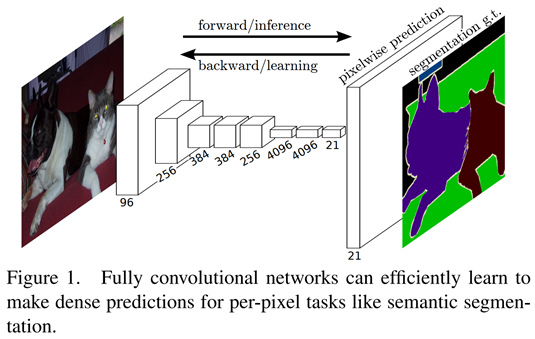




[Long et al., 2015](https://arxiv.org/abs/1411.4038)

Recall how to calculate the output shape of a convolutional layer. Since (320−64+16×2+32)/32=10  and  (480−64+16×2+32)/32=15 , we construct a transposed convolutional layer with stride of  32 , setting the height and width of the kernel to  32*2 = 64, the padding to  32/2 = 16. 

In general, we can see that for stride  s , padding  s/2  (assuming  s/2  is an integer), and the height and width of the kernel  2s , the transposed convolution will increase the height and width of the input by  s  times.

In [ ]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module(
    'transpose_conv',
    nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16,
                       stride=32))

In [ ]:
list(net.children())[-3:] 

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [ ]:
net(X).shape

torch.Size([1, 21, 320, 480])

## Next, we will intialize the weights for the transposed layer using bilinear interpolation. First, let us see how the bilinear interpolation works.

### Bilinear Interpoliation for initializing transposed covolutional layers
Bilinear interpolation is one of the commonly used upsampling techniques. It is also often used for initializing transposed convolutional layers.

The bilinear interpolant is not linear; but it is linear (i.e. affine) along lines parallel to either the x or the y direction, equivalently if x or y is held constant. Along any other straight line, the interpolant is quadratic.
https://en.wikipedia.org/wiki/Bilinear_interpolation

In [ ]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros(
        (in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

We construct a transposed convolutional layer that doubles the height and weight, and initialize its kernel with the bilinear_kernel function.

In [ ]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

Read the image X and assign the upsampling output to Y. In order to print the image, we need to adjust the position of the channel dimension.

In [ ]:
!dir

drive  sample_data


In [ ]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('/content/drive/MyDrive/d2l_pytorch/img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

As we can see, the transposed convolutional layer increases both the height and width of the image by a factor of two. Except for the different scales in coordinates, the image scaled up by bilinear interpolation and the original image printed in Section 13.3 look the same.

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


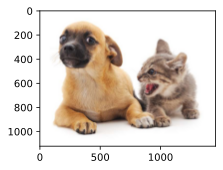

In [ ]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0))
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

## Initialize the transposed convolutional layer with upsampling of bilinear interpolation and Train and Test the previously constructed FCN.

In [ ]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

## Next, let us see how we can freeze parameters for transfer learning

### First check model parameters

In [ ]:
net.parameters

<bound method Module.parameters of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

### Show the last two layers (to be freezed)

In [ ]:
net[-2:].parameters

<bound method Module.parameters of Sequential(
  (final_conv): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
  (transpose_conv): ConvTranspose2d(21, 21, kernel_size=(64, 64), stride=(32, 32), padding=(16, 16))
)>

### Freeze all parameters except the last two layers.

In [ ]:
for parameter in net.parameters():
    parameter.requires_grad = False
for parameter in net[-2:].parameters():
    parameter.requires_grad = True

### Let us double check to see if the correct layers have been freezed. 

In [ ]:
for name, param in net.named_parameters():
    #print(name)
    if param.requires_grad:print(name)

final_conv.weight
final_conv.bias
transpose_conv.weight
transpose_conv.bias


## Create dataloaders

In [ ]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


read 1078 examples


loss 0.415, train acc 0.869, test acc 0.854
42.1 examples/sec on [device(type='cuda', index=0)]


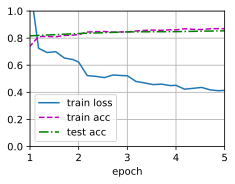

In [ ]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## Use the trained model to predict on the test dataset

In [ ]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

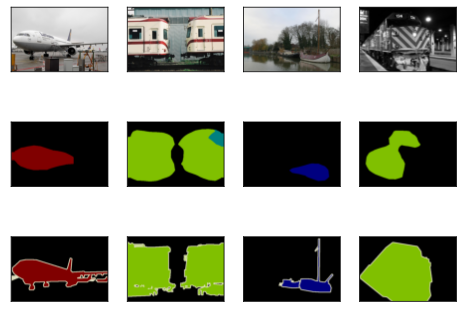

In [ ]:
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2, 0),
        pred.cpu(),
        torchvision.transforms.functional.crop(test_labels[i],
                                               *crop_rect).permute(1, 2, 0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);